In [93]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import AveragePooling2D, Convolution2D, MaxPooling2D, ZeroPadding2D                               
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.models import model_from_json
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
import keras
import h5py



%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import time
import os, csv
import PIL
from PIL import Image
from numpy import genfromtxt
import pandas as pd

In [2]:
#Load some system specific variables
csvFile = "/Users/chris/NortheasternClassCode/lisencePlate/lisencePlates/LiscencePlateBoxes.csv"
pathToImages = "/Users/chris/NortheasternClassCode/LisencePlate/plates_br-master/images/"
boxes=pd.read_csv(csvFile, sep=',',header=None)
scaledImageSize = (224,224)

(224, 224, 3)

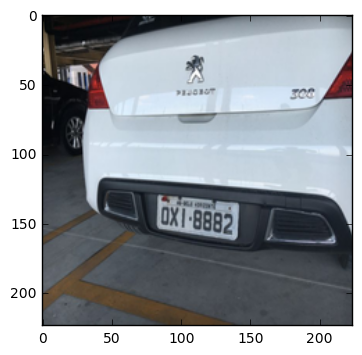

In [19]:
scaledImageSize = (224,224)
img = PIL.Image.open("/Users/chris/NortheasternClassCode/LisencePlate/plates_br-master/images/OXI-8882 (5).jpg")
img = img.resize(scaledImageSize, PIL.Image.ANTIALIAS)
A = np.asarray(img)
plt.imshow(A)
A.shape

In [53]:
#Organize Data so that it is in numpy arrays for the neural network
def changImageSize(fileName):
    img = PIL.Image.open(pathToImages+fileName) #Opens as a color image
    #img = mpimg.imread(pathToImages+fileName) #Opens as a black and white image
    #img = img.convert('L') #Converts color image to greyscale
    img = img.resize(scaledImageSize, PIL.Image.ANTIALIAS)
    return img
    
imageData = np.expand_dims(np.empty([3,224,224]), axis=0)
locationData = np.empty([1,4])
for root, dirs, files in os.walk(pathToImages):
    # shuffle the order samples
    numFiles = len(files)
    sampleOrder = np.random.choice(numFiles, size=numFiles, replace=False)
    for sample in sampleOrder:
        fileName = files[sample]
        for i in range(len(boxes)):
            if fileName == boxes[0][i]:
                img = changImageSize(fileName)
                q = np.expand_dims(np.asarray(img),axis=0)
                if len(q.shape) > 3:
                    imageData = np.concatenate((imageData, np.moveaxis(np.expand_dims(np.asarray(img),axis=0),3,1)), axis = 0)
                    locationData = np.concatenate((locationData,np.expand_dims((np.asarray([boxes[1][i],boxes[2][i],boxes[3][i],boxes[4][i]])), axis = 0)), axis = 0)
imageData = imageData[1:]           #These two lines get ride of the garbage that was
locationData = locationData[1:]     #created in the empty array with np.empty() above

In [54]:
#def diceCoefficient()

In [55]:
#Check dimensions of everything to make sure shape and datatype is correct
print "imageData Type: ", type(imageData)
print "imageData Shape: ", imageData.shape
print "locationData Type: ", type(locationData)
print "locationData Shape: ", locationData.shape

imageData Type:  <type 'numpy.ndarray'>
imageData Shape:  (88, 3, 224, 224)
locationData Type:  <type 'numpy.ndarray'>
locationData Shape:  (88, 4)


In [56]:
#normalize data
imageData = imageData/255.0

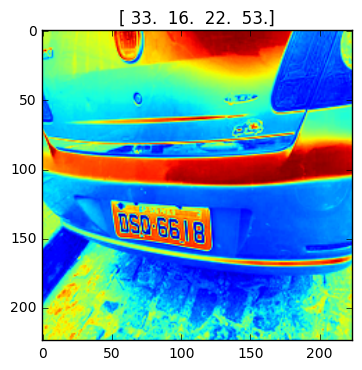

In [57]:
#Print example data to make sure everything looks good
x = 0
plt.imshow(imageData[x][2])
plt.title(str(locationData[x]))
plt.show()

In [58]:
#divide Data into test and train
#imageData = np.expand_dims(imageData, axis=1)
X_train = imageData[:80]
X_test = imageData[80:]
Y_train = locationData[:80]
Y_test = locationData[80:]

In [59]:
im_width = len(X_train[0][0])
im_height = len(X_train[0][0][0])
batch_size = 4
nb_epoch = 10
print X_train.shape
print "image Width: ", im_width
print "image height: ", im_height

(80, 3, 224, 224)
image Width:  224
image height:  224


In [108]:
base_model = VGG16(weights='imagenet')
#model = Model(input=base_model.input, output=base_model.get_layer('block4_pool').output)
#model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)

In [121]:
#save vgg16 json
#x = base_model.to_json()
#model = model_from_json(x)
#model.summary()
#save vggg 16weights
file800Epochs = 'vgg16weights'
model.load_weights(file800Epochs)
#base_model.save_weights('vgg16weights')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, 224, 224)  1792        input_7[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, 224, 224)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, 112, 112)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [156]:
# build the VGG16 network
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(3, im_width, im_height)))

model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))

print  model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_79 (ZeroPadding2D) (None, 3, 226, 226)   0           zeropadding2d_input_7[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, 224, 224)  1792        zeropadding2d_79[0][0]           
____________________________________________________________________________________________________
zeropadding2d_80 (ZeroPadding2D) (None, 64, 226, 226)  0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 64, 224, 224)  36928       zeropadding2d_80[0][0]           
___________________________________________________________________________________________

In [157]:
file800Epochs = 'vgg16weights'
model.load_weights(file800Epochs)
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.add(Dense(4, activation='softmax'))

print  model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_79 (ZeroPadding2D) (None, 3, 226, 226)   0           zeropadding2d_input_7[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, 224, 224)  1792        zeropadding2d_79[0][0]           
____________________________________________________________________________________________________
zeropadding2d_80 (ZeroPadding2D) (None, 64, 226, 226)  0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 64, 224, 224)  36928       zeropadding2d_80[0][0]           
___________________________________________________________________________________________

In [158]:
#Compile the new model
model.compile(optimizer='rmsprop',loss='mse', metrics=['accuracy'])

In [159]:
start = time.time()
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))
end = time.time()

Train on 80 samples, validate on 8 samples
Epoch 1/10
80/80 [==============================] - 382s - loss: 2226.0892 - acc: 0.5000 - val_loss: 1850.0266 - val_acc: 0.1250
Epoch 2/10
80/80 [==============================] - 436s - loss: 2225.9341 - acc: 0.5125 - val_loss: 1850.0201 - val_acc: 0.1250
Epoch 3/10
80/80 [==============================] - 413s - loss: 2225.8065 - acc: 0.5000 - val_loss: 1850.0165 - val_acc: 0.1250
Epoch 4/10
80/80 [==============================] - 385s - loss: 2225.6607 - acc: 0.5000 - val_loss: 1850.0129 - val_acc: 0.1250
Epoch 5/10
80/80 [==============================] - 412s - loss: 2225.5162 - acc: 0.5125 - val_loss: 1850.0111 - val_acc: 0.1250
Epoch 6/10
80/80 [==============================] - 511s - loss: 2225.4012 - acc: 0.5125 - val_loss: 1850.0071 - val_acc: 0.1250
Epoch 7/10
80/80 [==============================] - 504s - loss: 2225.3162 - acc: 0.5125 - val_loss: 1849.9994 - val_acc: 0.1250
Epoch 8/10
80/80 [==============================] - 45

In [160]:
score = model.evaluate(X_test, Y_test, verbose=0)

print ('Test score:   ', score[0])
print( 'Test accuracy:', score[1])
print( 'Time elapsed: ',(end - start), "seconds")

('Test score:   ', 1849.9761962890625)
('Test accuracy:', 0.125)
('Time elapsed: ', 4431.445886850357, 'seconds')


In [161]:
outPutSize = (400,400)
orgionalSize = 100.0

        
def scaleNumbers(w,h,x,y):
    factor =  outPutSize[0]/orgionalSize
    if (int(factor*x) > origional):
        a = origional
    elif (int(factor*x) < 0):
        a = 0
    else:
        a = int(factor*x)
    
    if (int(factor*y) > origional):
        b = origional
    elif (int(factor*y) < 0):
        b = 0
    else:
        b = int(factor*y)
        
    if (int(factor*w+(factor*x)) > origional):
        c = origional
    elif (int(factor*w+(factor*x)) < 0):
        c = 0
    else:
        c = int(factor*w+(factor*x))
    
    if (int(factor*h+(factor*y)) > origional):
        d = origional
    elif (int(factor*h+(factor*y)) < 0):
        d = 0
    else:
        d = int(factor*h+(factor*y))
    
    return (a,b,c,d)

def cropImage(fileName,w,h,x,y):
    img = PIL.Image.open(path+fileName)
    img = img.resize(outPutSize, PIL.Image.ANTIALIAS)
    img = img.crop(scaleNumbers(w,h,x,y))
    img.save(newPath+fileName)

In [162]:
print [1,2]

[1, 2]


In [ ]:
start = time.time()
prediction = model.predict(X_train)[0]
end = time.time()
print end-start, 'seconds'

In [ ]:
print prediction

In [ ]:
a = [0]*93
A = np.expand_dims(imageData, axis=1)

In [ ]:
for i in range(len(A)):
    a[i] = (model.predict(A[i])[0]).tolist()

In [ ]:
print imageData.shape
print A.shape
print X.shape

In [ ]:
newPath = "/Users/chris/Desktop/croppedPlates/"
outPutSize = (400,400)
orgionalSize = 100.0


boxes=pd.read_csv(csvFile, sep=',',header=None)
dirs = os.listdir( pathToImages )

def scaleNumbers(w,h,x,y):
    factor =  outPutSize[0]/orgionalSize
    return (int(factor*x), int(factor*y), int(factor*w+(factor*x)), int(factor*h+(factor*y)))

def cropImage(fileName,w,h,x,y):
    img = PIL.Image.open(pathToImages+fileName)
    img = img.resize(outPutSize, PIL.Image.ANTIALIAS)
    img = img.crop(scaleNumbers(w,h,x,y))
    img.save(newPath+fileName)

for root, dirs, files in os.walk(pathToImages):
    for fileName in files:
        for i in range(len(boxes)):
            if fileName == boxes[0][i]:
                cropImage(fileName,a[i][0],a[i][1],a[i][2],a[i][3])